# **PROBLEMA DE NEGOCIO**


---




## Una empresa de telecomunicaciones desea mejorar la retención de sus clientes, identificando aquellos que tienen más chances de abandonar el servicio (Churn). Como científico de datos, tu objetivo será limpiar y preparar un conjunto de datos para el entrenamiento de un modelo de Churn. A continuación, se presentan las preguntas clave que guiarán el proceso de limpieza de datos:

### **Preguntas**

1. ¿Qué insights podemos obtener del análisis exploratorio inicial del conjunto de datos?

2. ¿Qué transformaciones básicas son necesarias para preparar los datos?

3. ¿Cómo podemos identificar y tratar los datos duplicados y los valores nulos?

4. ¿Cómo manejamos los outliers presentes en el dataset?

5. ¿Qué técnicas aplicamos para procesar las variables categóricas?

# **1. Configuración del Ambiente**


---




In [73]:
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
global datos_churn

# **2. Obtención y Tratamiento de Datos**


---




## **2.1 Cargando las bases de datos**

In [2]:
datos_churn = pd.read_json("base_clientes.json")
datos_churn.head()

,id_cliente,Churn,cliente,telefono,internet,cuenta
0,0002-ORFBO,no,"{'genero': 'femenino', 'anciano': 0, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': None, 'facturacion_electronica': ..."
1,0003-MKNFE,no,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': 'mensual', 'facturacion_electroni..."
2,0004-TLHLJ,si,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
3,0011-IGKFF,si,"{'genero': 'masculino', 'anciano': 1, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
4,0013-EXCHZ,si,"{'genero': 'femenino', 'anciano': 1, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."


Cargamos los datos que se encuentran en formato JSON

In [3]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  7344 non-null   object
 1   Churn       7344 non-null   object
 2   cliente     7344 non-null   object
 3   telefono    7344 non-null   object
 4   internet    7344 non-null   object
 5   cuenta      7344 non-null   object
dtypes: object(6)
memory usage: 344.4+ KB


Observamos que tenemos 7344 valores totales, pero adentro encontramos las diferentes columnas. 

In [4]:
def lectura_datos(data):

  with open ('base_clientes.json',encoding='utf-8') as f:
    json_bruto=json.load(f)
    datos_churn=pd.json_normalize(json_bruto)
    return datos_churn
  
  
datos_churn=lectura_datos(datos_churn)
    

Convertimos los datos JSON, en formato de tabla, para una mejor comprension de estos 

In [5]:
datos_churn.head()

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0002-ORFBO,no,femenino,0,si,si,9.0,si,no,DSL,no,si,no,si,si,no,None,None,None,NaN,None
1,0003-MKNFE,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.9,542.4
2,0004-TLHLJ,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.9,280.85
3,0011-IGKFF,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.0,1237.85
4,0013-EXCHZ,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.9,267.4


## **2.2 Tratamiento de datos**

In [6]:
with open('./Diccionario.txt', 'r', encoding='utf-8') as file:
    contenido = file.read()
print(contenido)

La base de datos contiene columnas además del ID de los clientes y el churn:

Cliente:
género: género (masculino y femenino)
anciano: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
pareja: si el cliente tiene o no una pareja
dependientes: si el cliente tiene o no dependientes
tiempo_servicio: meses de contrato del cliente

Servicio de telefonía:
servicio_telefono: suscripción al servicio telefónico
varias_lineas: suscripción a más de una línea telefónica

Servicio de internet:
servicio_internet: suscripción a un proveedor de internet
seguridad_online: suscripción adicional a seguridad en línea
backup_online: suscripción adicional a copias de seguridad en línea
proteccion_dispositivo: suscripción adicional a protección en el dispositivo
soporte_tecnico: suscripción adicional a soporte técnico, menos tiempo de espera
tv_streaming: suscripción a TV por cable
peliculas_streaming: suscripción a streaming de películas

Cuenta:
contrato: tipo de contrato
factura_e

In [7]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7344 non-null   object 
 1   Churn                            7344 non-null   object 
 2   cliente.genero                   7344 non-null   object 
 3   cliente.anciano                  7344 non-null   int64  
 4   cliente.pareja                   7344 non-null   object 
 5   cliente.dependientes             7344 non-null   object 
 6   cliente.tiempo_servicio          7336 non-null   float64
 7   telefono.servicio_telefono       7344 non-null   object 
 8   telefono.varias_lineas           7344 non-null   object 
 9   internet.servicio_internet       7344 non-null   object 
 10  internet.seguridad_online        7344 non-null   object 
 11  internet.backup_online           7344 non-null   object 
 12  internet.proteccion_

In [8]:
datos_churn.isna().sum()/datos_churn.shape[1]

id_cliente                         0.000000
Churn                              0.000000
cliente.genero                     0.000000
cliente.anciano                    0.000000
cliente.pareja                     0.000000
cliente.dependientes               0.000000
cliente.tiempo_servicio            0.380952
telefono.servicio_telefono         0.000000
telefono.varias_lineas             0.000000
internet.servicio_internet         0.000000
internet.seguridad_online          0.000000
internet.backup_online             0.000000
internet.proteccion_dispositivo    0.000000
internet.soporte_tecnico           0.000000
internet.tv_streaming              0.000000
internet.peliculas_streaming       0.000000
cuenta.contrato                    1.523810
cuenta.facturacion_electronica     0.857143
cuenta.metodo_pago                 1.285714
cuenta.cobros.mensual              0.857143
cuenta.cobros.Total                0.761905
dtype: float64

La columna con mas valores faltantes se encuetra en cuenta.contrato con 1.5% de los datos. 

In [9]:
columnas=datos_churn.columns

for columnas in columnas:
    print('Columna',columnas)
    print(datos_churn[columnas].value_counts())
    print('---------------------------------')

Columna id_cliente
id_cliente
0793-TWELN    2
7176-WIONM    2
2371-JQHZZ    2
1193-RTSLK    2
2192-CKRLV    2
             ..
3401-URHDA    1
3400-ESFUW    1
3399-BMLVW    1
3398-ZOUAA    1
9995-HOTOH    1
Name: count, Length: 7267, dtype: int64
---------------------------------
Columna Churn
Churn
no    5223
si    1895
       226
Name: count, dtype: int64
---------------------------------
Columna cliente.genero
cliente.genero
masculino    3713
femenino     3631
Name: count, dtype: int64
---------------------------------
Columna cliente.anciano
cliente.anciano
0    6147
1    1197
Name: count, dtype: int64
---------------------------------
Columna cliente.pareja
cliente.pareja
no    3793
si    3551
Name: count, dtype: int64
---------------------------------
Columna cliente.dependientes
cliente.dependientes
no    5143
si    2201
Name: count, dtype: int64
---------------------------------
Columna cliente.tiempo_servicio
cliente.tiempo_servicio
1.0       639
72.0      374
2.0       249
3.0

Encontramos algo interesante en la columna Cobros toal tenemos 11 columnas sin ningun tipo de valor al igual que nuestra variable objetivo CHURN tuene 226 registros vacios.

In [10]:
datos_churn[datos_churn['Churn'] == '']

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
30,0047-ZHDTW,,femenino,0,no,no,11.0,si,si,fibra optica,si,no,no,no,no,no,mensual,si,transferencia bancaria (automatica),79.00,929.3
75,0120-YZLQA,,masculino,0,no,no,71.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,dos años,si,tarjeta de credito (automatico),19.90,1355.1
96,0154-QYHJU,,masculino,0,no,no,29.0,si,no,DSL,si,si,no,si,no,no,un año,si,cheque electronico,58.75,1696.2
98,0162-RZGMZ,,femenino,1,no,no,5.0,si,no,DSL,si,si,no,si,no,no,mensual,no,tarjeta de credito (automatico),59.90,287.85
175,0274-VVQOQ,,masculino,1,si,no,65.0,si,si,fibra optica,no,si,si,no,si,si,un año,si,transferencia bancaria (automatica),103.15,6792.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,9920-GNDMB,,masculino,0,no,no,9.0,si,si,fibra optica,no,no,no,no,no,no,mensual,si,cheque electronico,76.25,684.85
7239,9955-RVWSC,,femenino,0,si,si,67.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,dos años,si,transferencia bancaria (automatica),19.25,1372.9
7247,9966-VYRTZ,,femenino,0,si,si,31.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,mensual,si,cheque,19.55,658.95
7267,6532-YOHZY,,masculino,0,si,si,45.0,si,si,fibra optica,no,si,si,si,si,si,dos años,si,transferencia bancaria (automatica),109.75,4900.65


In [11]:
datos_churn[datos_churn['cuenta.cobros.Total'] == ' '][['cliente.tiempo_servicio','cuenta.contrato','cuenta.facturacion_electronica','cuenta.cobros.mensual','cuenta.cobros.Total']]


,cliente.tiempo_servicio,cuenta.contrato,cuenta.facturacion_electronica,cuenta.cobros.mensual,cuenta.cobros.Total
975,0.0,dos años,no,56.05,
1775,0.0,dos años,no,20.00,
1955,0.0,dos años,si,61.90,
2075,0.0,dos años,si,19.70,
2232,0.0,dos años,no,20.25,
2308,0.0,dos años,no,25.35,
2930,0.0,dos años,no,73.35,
3134,0.0,dos años,no,25.75,
3203,0.0,dos años,si,52.55,
4169,0.0,dos años,no,80.85,


Podriamos suponer que las columna tiempo_servicio se podria rellenar con 24 que refiere a dos años pero no sabemos el cliente en realidad, cuanto tiempo tiene con la empresa. 

In [12]:
datos_con_nulos = datos_churn[datos_churn.isna().any(axis=1)][['cliente.tiempo_servicio', 'cuenta.contrato',
       'cuenta.facturacion_electronica', 'cuenta.metodo_pago',
       'cuenta.cobros.mensual', 'cuenta.cobros.Total']].head(15)

datos_con_nulos

,cliente.tiempo_servicio,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,9.0,None,None,None,NaN,None
9,NaN,dos años,si,cheque,90.45,5957.9
181,NaN,mensual,si,cheque,29.30,355.9
186,NaN,mensual,si,tarjeta de credito (automatico),63.95,318.1
452,67.0,None,None,tarjeta de credito (automatico),NaN,6886.25
773,NaN,dos años,si,transferencia bancaria (automatica),101.05,5971.25
994,21.0,None,si,None,NaN,1565.7
1645,18.0,None,no,None,20.05,None
1646,23.0,None,no,None,NaN,None
1647,55.0,None,si,tarjeta de credito (automatico),NaN,None


In [13]:
datos_con_nulos.shape

(15, 6)

Podemos observar que los nulos no tienen un patron claro para poder remplazarlos, y en algunos casos algunas columnas estan casi vacias. 

In [14]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7344 non-null   object 
 1   Churn                            7344 non-null   object 
 2   cliente.genero                   7344 non-null   object 
 3   cliente.anciano                  7344 non-null   int64  
 4   cliente.pareja                   7344 non-null   object 
 5   cliente.dependientes             7344 non-null   object 
 6   cliente.tiempo_servicio          7336 non-null   float64
 7   telefono.servicio_telefono       7344 non-null   object 
 8   telefono.varias_lineas           7344 non-null   object 
 9   internet.servicio_internet       7344 non-null   object 
 10  internet.seguridad_online        7344 non-null   object 
 11  internet.backup_online           7344 non-null   object 
 12  internet.proteccion_

In [15]:
datos_churn.describe()

,cliente.anciano,cliente.tiempo_servicio,cuenta.cobros.mensual
count,7344.000000,7336.000000,7326.000000
mean,0.162990,33.271265,64.683770
std,0.369382,35.776684,30.143033
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.362500
50%,0.000000,29.000000,70.300000
75%,0.000000,56.000000,89.887500
max,1.000000,1080.000000,118.750000


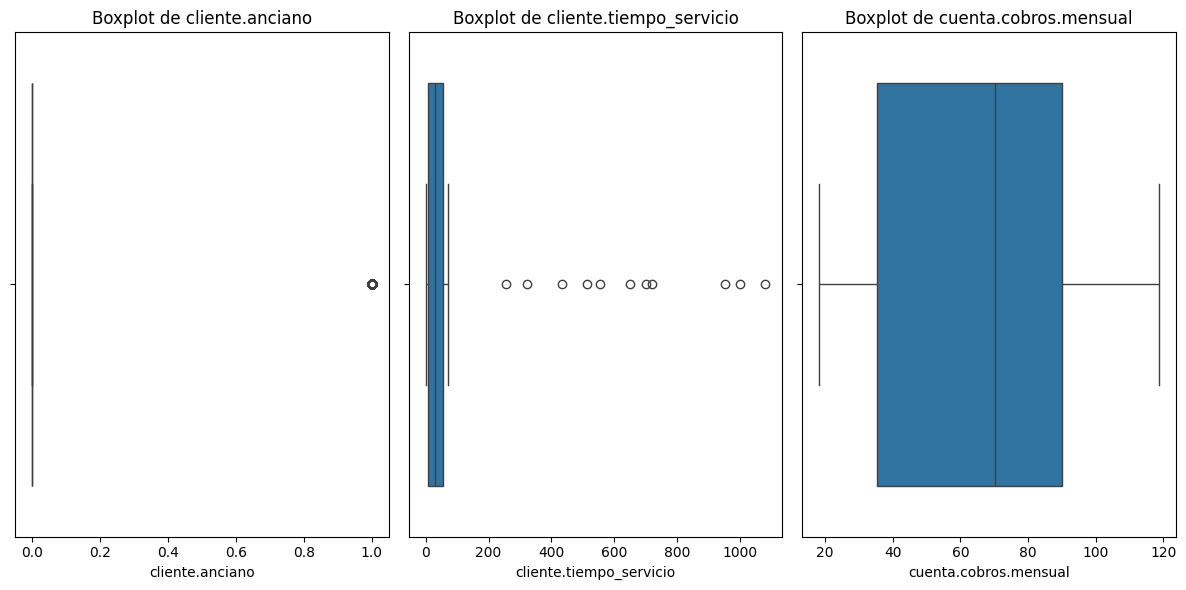

In [16]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear los subplots
plt.subplot(1, 3, 1)
sns.boxplot(x='cliente.anciano', data=datos_churn)
plt.title('Boxplot de cliente.anciano')

plt.subplot(1, 3, 2)
sns.boxplot(x='cliente.tiempo_servicio', data=datos_churn)
plt.title('Boxplot de cliente.tiempo_servicio')

plt.subplot(1, 3, 3)
sns.boxplot(x='cuenta.cobros.mensual', data=datos_churn)
plt.title('Boxplot de cuenta.cobros.mensual')

# Ajustar el layout para que no se superpongan los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En la columna tiempo de servicio, tenemos bastantes otliers vamos a tratarlos. 

## 2.2 Tratamiento de Datos

In [17]:
def preprocesamiento(datos_churn):


  #=====================================================================
                            #Limpieza de outliers
  #=====================================================================
    # Calcular cuartiles e IQR
  primer_cuartil = datos_churn['cliente.tiempo_servicio'].quantile(0.25)
  tercer_cuartil = datos_churn['cliente.tiempo_servicio'].quantile(0.75)
  IQR = tercer_cuartil - primer_cuartil

  # Calcular los límites para considerar los valores atípicos
  limite_inferior = primer_cuartil - 1.5 * IQR
  limite_superior = tercer_cuartil + 1.5 * IQR

  # Filtrar los valores que están dentro de los límites
  datos_churn = datos_churn[datos_churn['cliente.tiempo_servicio'].between(limite_inferior, limite_superior)]
    #=====================================================================
                #Relleno de los valores "" en las columnas con nan 
  #=====================================================================
  
    #Primera columna en los datos churn cambairemos los valores '' por nan para despues eliminarlos.
  datos_churn['Churn']=datos_churn['Churn'].replace('',np.nan)
  #Segunda Columna en los datos cuenta.cobros.Total cambairemos los valores '' por nan para despues eliminarlos.
  datos_churn['cuenta.cobros.Total'] = datos_churn['cuenta.cobros.Total'].replace(' ', np.nan)
  
   #=====================================================================
                            #Limpieza de duplicados y nulos
  #=====================================================================
  datos_churn=datos_churn.dropna()
  datos_churn=datos_churn.drop_duplicates().reset_index(drop=True)   
  
  datos_churn['cuenta.cobros.Total']=datos_churn['cuenta.cobros.Total'].astype('float')
  
  return datos_churn
  


In [18]:
datos_churn=preprocesamiento(datos_churn)

C:\Users\Gabriel Chavez\AppData\Local\Temp\ipykernel_18240\1577201658.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_churn['Churn']=datos_churn['Churn'].replace('',np.nan)
C:\Users\Gabriel Chavez\AppData\Local\Temp\ipykernel_18240\1577201658.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_churn['cuenta.cobros.Total'] = datos_churn['cuenta.cobros.Total'].replace(' ', np.nan)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       6977 non-null   object 
 1   Churn                            6977 non-null   object 
 2   cliente.genero                   6977 non-null   object 
 3   cliente.anciano                  6977 non-null   int64  
 4   cliente.pareja                   6977 non-null   object 
 5   cliente.dependientes             6977 non-null   object 
 6   cliente.tiempo_servicio          6977 non-null   float64
 7   telefono.servicio_telefono       6977 non-null   object 
 8   telefono.varias_lineas           6977 non-null   object 
 9   internet.servicio_internet       6977 non-null   object 
 10  internet.seguridad_online        6977 non-null   object 
 11  internet.backup_online           6977 non-null   object 
 12  internet.proteccion_

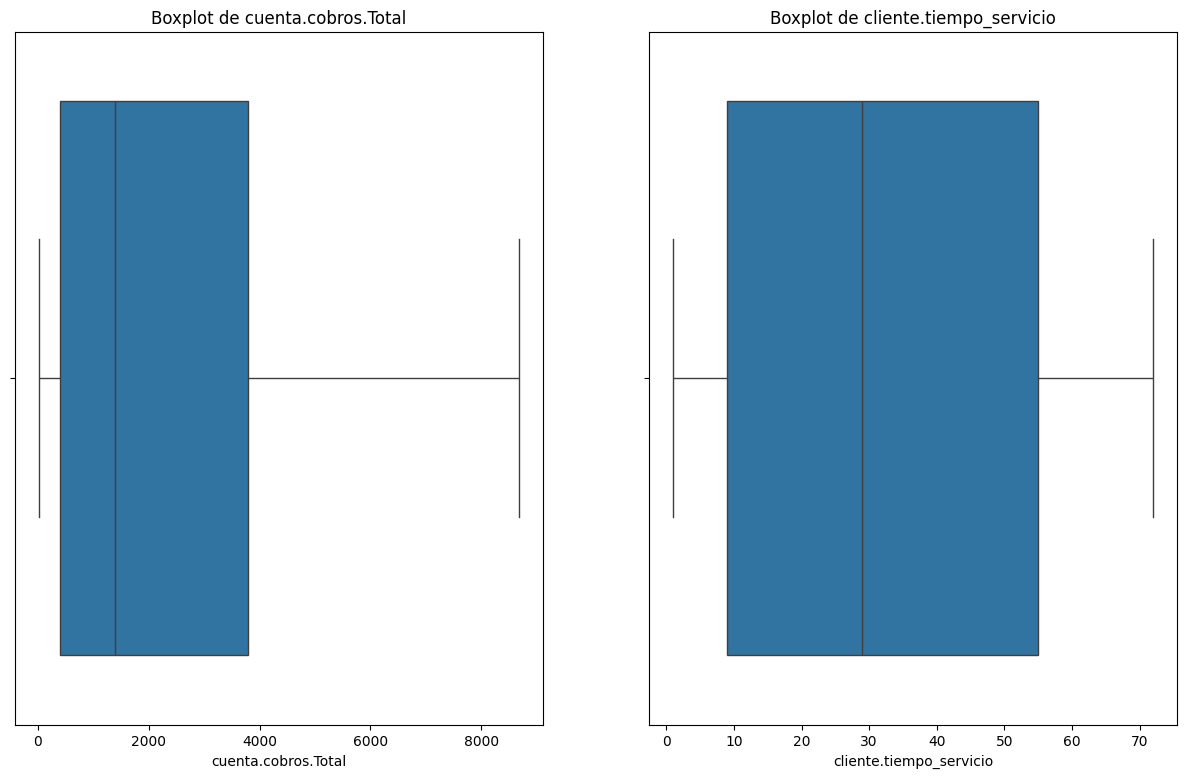

In [19]:
    #=====================================================================
                        #Verificación de los Datos
#=====================================================================
datos_churn.info()
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 9))

# Crear los subplots
plt.subplot(1, 2, 1)
sns.boxplot(x='cuenta.cobros.Total', data=datos_churn)
plt.title('Boxplot de cuenta.cobros.Total')

plt.subplot(1, 2, 2)
sns.boxplot(x='cliente.tiempo_servicio', data=datos_churn)
plt.title('Boxplot de cliente.tiempo_servicio')
plt.show()

## **2.3 Normalizacion de datos**

In [20]:
for col in datos_churn.columns:
    print(f"Columna: {col}")
    print(datos_churn[col].unique())
    print("-" * 30)

Columna: id_cliente
['0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Columna: Churn
['no' 'si']
------------------------------
Columna: cliente.genero
['masculino' 'femenino']
------------------------------
Columna: cliente.anciano
[0 1]
------------------------------
Columna: cliente.pareja
['no' 'si']
------------------------------
Columna: cliente.dependientes
['no' 'si']
------------------------------
Columna: cliente.tiempo_servicio
[ 9.  4. 13.  3. 71. 63.  7. 54. 72.  5. 56. 34.  1. 45. 50. 23. 55. 26.
 69. 37. 49. 66. 67. 20. 43. 59. 12. 27.  2. 25. 29. 14. 35. 64. 39. 40.
 11.  6. 30. 70. 57. 58. 16. 32. 33. 10. 21. 61. 15. 44. 22. 24. 19. 47.
 62. 46. 52.  8. 60. 48. 28. 41. 53. 68. 31. 36. 17. 18. 65. 51. 38. 42.]
------------------------------
Columna: telefono.servicio_telefono
['si' 'no']
------------------------------
Columna: telefono.varias_lineas
['si' 'no' 'sin servicio de telefono']
-----------------

In [21]:
datos_churn.drop('id_cliente',axis=1,inplace=True)

In [22]:
datos_churn.head()

,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.9,542.40
1,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.9,280.85
2,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.0,1237.85
3,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.9,267.40
4,no,femenino,0,no,si,9.0,si,no,DSL,no,no,no,si,si,si,mensual,si,tarjeta de credito (automatico),69.4,571.45


In [23]:
datos_churn['Churn']=datos_churn['Churn'].apply(lambda x: '0' if x == 'no' else '1').astype('int')
datos_churn.head(1)

,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.9,542.4


In [24]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Churn                            6977 non-null   int32  
 1   cliente.genero                   6977 non-null   object 
 2   cliente.anciano                  6977 non-null   int64  
 3   cliente.pareja                   6977 non-null   object 
 4   cliente.dependientes             6977 non-null   object 
 5   cliente.tiempo_servicio          6977 non-null   float64
 6   telefono.servicio_telefono       6977 non-null   object 
 7   telefono.varias_lineas           6977 non-null   object 
 8   internet.servicio_internet       6977 non-null   object 
 9   internet.seguridad_online        6977 non-null   object 
 10  internet.backup_online           6977 non-null   object 
 11  internet.proteccion_dispositivo  6977 non-null   object 
 12  internet.soporte_tec

In [25]:
features = datos_churn.drop('Churn', axis=1) #x
target = datos_churn['Churn'] #y
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=12345)

In [26]:
X_test.head()

,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
5598,masculino,0,no,no,47.0,si,si,fibra optica,no,si,si,no,si,si,un año,si,cheque electronico,103.10,4889.30
5942,femenino,0,si,no,57.0,si,si,fibra optica,si,no,no,no,si,si,mensual,si,cheque electronico,99.65,5497.05
2149,femenino,0,si,no,68.0,si,si,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,dos años,no,tarjeta de credito (automatico),25.80,1911.50
4505,femenino,0,no,no,6.0,si,si,fibra optica,si,no,no,no,no,no,mensual,si,cheque electronico,79.05,434.50
28,masculino,0,si,si,37.0,si,no,fibra optica,no,no,no,no,si,si,un año,no,tarjeta de credito (automatico),91.20,3247.55


In [45]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
columns_object=datos_churn.select_dtypes(include='object').columns
enc = OrdinalEncoder()
X_train[columns_object] = enc.fit_transform(X_train[columns_object])
X_test[columns_object] = enc.transform(X_test[columns_object])
X_test.head()

,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
5598,1.0,0,0.0,0.0,47.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,103.10,4889.30
5942,0.0,0,1.0,0.0,57.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,99.65,5497.05
2149,0.0,0,1.0,0.0,68.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,25.80,1911.50
4505,0.0,0,0.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,79.05,434.50
28,1.0,0,1.0,1.0,37.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,2.0,91.20,3247.55


In [46]:
from imblearn.over_sampling import RandomOverSampler
os_us = RandomOverSampler()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
resultado=pd.concat([X_train_res, y_train_res], axis=1)
resultado['Churn'].value_counts()

Churn
0    4110
1    4110
Name: count, dtype: int64

#**3. Modelo Random Forest**


---


In [47]:
def pronosticar(train_x, train_y):
  model = RandomForestClassifier(random_state=50)
  model.fit(train_x, train_y)
  return model

In [48]:
model = pronosticar(X_train, y_train)
model.score(X_test, y_test)

0.7994269340974212

#**4. Reducción de Dimensionalidad**


---


In [38]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
columns_object=datos_churn.select_dtypes(include='object').columns
enc = OrdinalEncoder()
datos_churn[columns_object] = enc.fit_transform(datos_churn[columns_object])
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Churn                            6977 non-null   int32  
 1   cliente.genero                   6977 non-null   float64
 2   cliente.anciano                  6977 non-null   int64  
 3   cliente.pareja                   6977 non-null   float64
 4   cliente.dependientes             6977 non-null   float64
 5   cliente.tiempo_servicio          6977 non-null   float64
 6   telefono.servicio_telefono       6977 non-null   float64
 7   telefono.varias_lineas           6977 non-null   float64
 8   internet.servicio_internet       6977 non-null   float64
 9   internet.seguridad_online        6977 non-null   float64
 10  internet.backup_online           6977 non-null   float64
 11  internet.proteccion_dispositivo  6977 non-null   float64
 12  internet.soporte_tec

In [39]:
datos_churn.drop(columns=['cuenta.cobros.mensual','cuenta.cobros.Total','cliente.tiempo_servicio'],inplace=True)

KeyError: "['cuenta.cobros.mensual', 'cuenta.cobros.Total'] not found in axis"

In [40]:
datos_churn.drop(columns=['cliente.tiempo_servicio'],inplace=True)

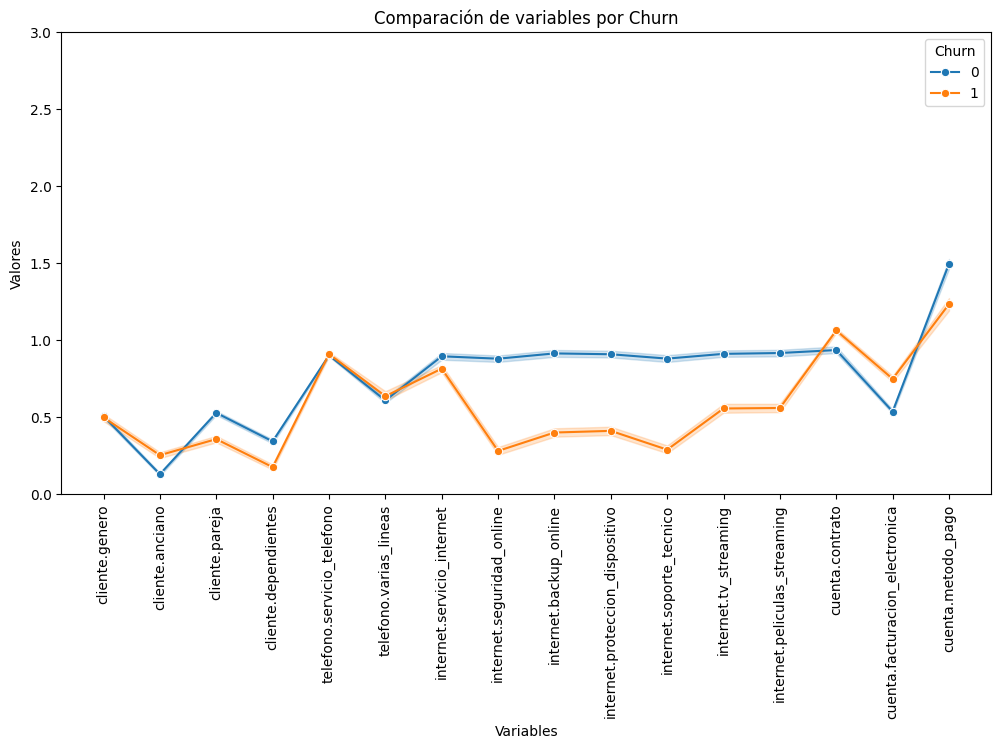

In [41]:
# Transforma los datos a un formato adecuado para Seaborn
df_melted = datos_churn.melt(id_vars='Churn', var_name='Variables', value_name='Valores')

# Grafico con Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Variables', y='Valores', hue='Churn', marker='o')

plt.xticks(rotation=90)  # Rotar etiquetas del eje x
plt.ylim(df_melted['Valores'].min(), df_melted['Valores'].max())
plt.title('Comparación de variables por Churn')
plt.show()

In [42]:
datos_churn.groupby('Churn')["telefono.varias_lineas"].value_counts(normalize=True)

Churn  telefono.varias_lineas
0      0.0                       0.490636
       1.0                       0.410456
       2.0                       0.098908
1      0.0                       0.454889
       1.0                       0.454349
       2.0                       0.090762
Name: proportion, dtype: float64

In [43]:
datos_churn.groupby('Churn')["internet.servicio_internet"].value_counts(normalize=True)

Churn  internet.servicio_internet
0      0.0                           0.378073
       1.0                           0.349005
       2.0                           0.272922
1      1.0                           0.692599
       0.0                           0.246353
       2.0                           0.061048
Name: proportion, dtype: float64

In [34]:
df_melted

,Churn,Variables,Valores
0,0,cliente.genero,1.00
1,1,cliente.genero,1.00
2,1,cliente.genero,1.00
3,1,cliente.genero,0.00
4,0,cliente.genero,0.00
...,...,...,...
132558,0,cuenta.cobros.Total,742.90
132559,1,cuenta.cobros.Total,1873.70
132560,0,cuenta.cobros.Total,92.75
132561,0,cuenta.cobros.Total,4627.65


##**4.1 Métodos Gráficos**

In [51]:
def diagrama_violin(df, inicio, fin):
    df=df[df.select_dtypes(include='int32').columns]
    y=df['Churn']
    x=df.drop(columns='Churn')
    df=pd.concat([y,x.iloc[:,inicio:fin]],axis=1)
    df_melt=pd.melt(df,id_vars='Churn',var_name='features',value_name='valores')
    plt.figure(figsize=(12,6))
    sns.pointplot(x='features', y='valores',hue='Churn',data=df_melt)
    plt.xticks(rotation=90)
    plt.show()

#def diagrama_puntos(df, inicio, fin):
    #Tu código aquí

def mapa_calor(df):
    grafico = df.corr()
    plt.figure( figsize = (17,15))
    sns.heatmap(grafico, annot = True, fmt = ".1f")
    return grafico

In [37]:
datos_churn.groupby('Churn')["telefono.varias_lineas"].value_counts(normalize=True)

Churn  telefono.varias_lineas
0      0.0                       0.490636
       1.0                       0.410456
       2.0                       0.098908
1      0.0                       0.454889
       1.0                       0.454349
       2.0                       0.090762
Name: proportion, dtype: float64

In [50]:
train_x = X_train.drop(columns=["telefono.varias_lineas",'internet.servicio_internet'])
test_x = X_test.drop(columns=["telefono.varias_lineas",'internet.servicio_internet'])
model = pronosticar(train_x, y_train)
model.score(test_x, y_test)

0.8015759312320917

##**4.2 Mapa de Calor**

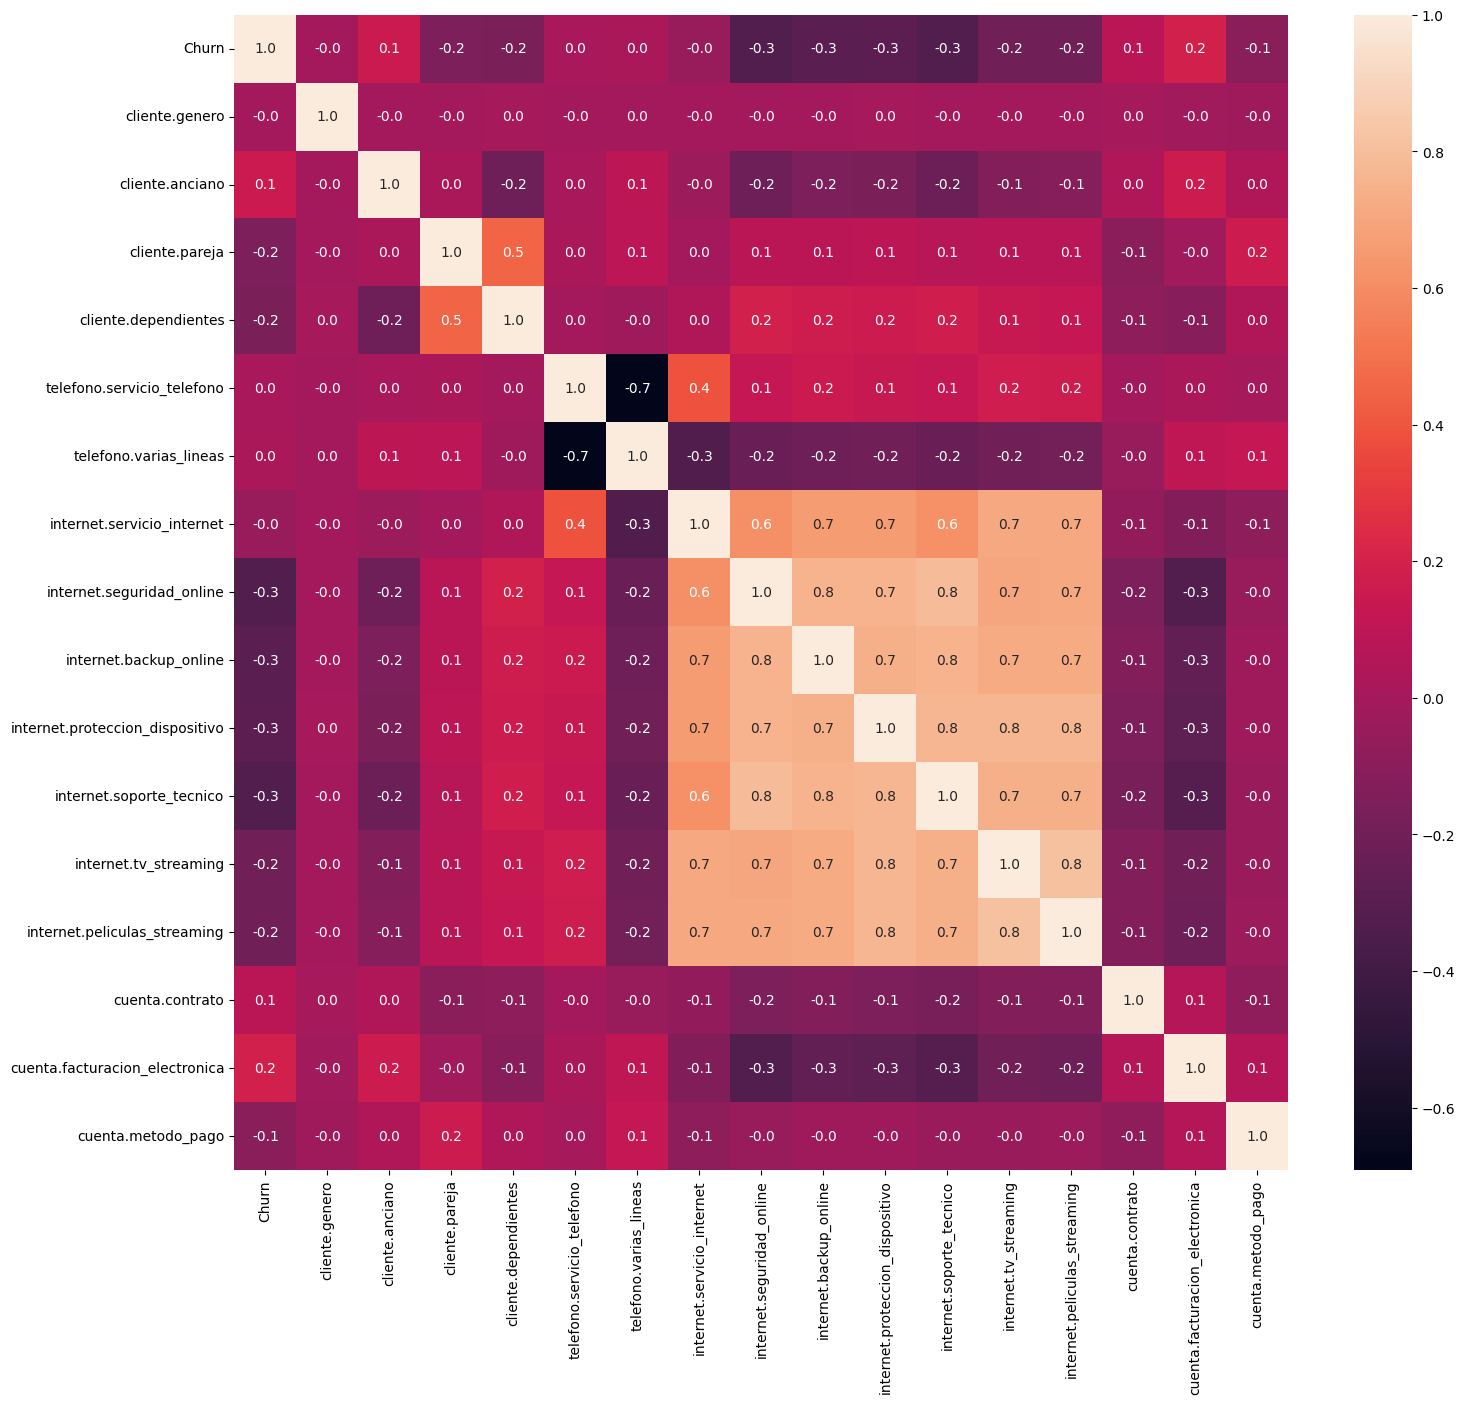

In [52]:
matriz = mapa_calor(datos_churn)

In [56]:
matriz2 = matriz>0.80
matriz2 = matriz2.sum()
matriz2[matriz2>1]

internet.tv_streaming           2
internet.peliculas_streaming    2
dtype: int64

In [ ]:
def identificar_variables(base):
  #Tu código aquí

In [ ]:
identificar_variables(matriz2[matriz2>1])

In [58]:
train_x = X_train.drop(columns=["internet.tv_streaming",'internet.peliculas_streaming'])
test_x = X_test.drop(columns=["internet.tv_streaming",'internet.peliculas_streaming'])
model = pronosticar(train_x, y_train)
model.score(test_x, y_test)

0.8051575931232091

##**4.3 Feature Importances**

In [78]:
def pronosticar_kbest(train_x, test_x, train_y, test_y):
    start_time = time.time()
    mejor_k = 0
    mejor_score = 0
    mejores_columnas = []

    for k in range(1, train_x.shape[1] + 1):
        seleccionar_mejores = SelectKBest(chi2, k=k)
        seleccionar_mejores.fit(train_x, train_y)
        train_x_kbest = seleccionar_mejores.transform(train_x)
        
        # Entrenar el modelo
        model = RandomForestClassifier(random_state=50)
        scores = cross_val_score(model, train_x_kbest, train_y, cv=5, scoring='accuracy')
        score = scores.mean()

        if score > mejor_score:
            mejor_k = k
            mejor_score = score
            mejor_seleccionador = seleccionar_mejores
            mejores_columnas = seleccionar_mejores.get_support(indices=True)
    
    # Imprimir resultados
    print(f"Mejor número de características: {mejor_k}")
    print(f"Mejor accuracy: {mejor_score:.4f}")
    print("Mejores columnas seleccionadas:", train_x.columns[mejores_columnas])
    
    # Entrenar el modelo final con las mejores características
    mejor_model = RandomForestClassifier(random_state=50)
    mejor_model.fit(train_x.iloc[:, mejores_columnas], train_y)

    # Evaluar en el conjunto de prueba
    test_x_kbest = test_x.iloc[:, mejores_columnas]
    test_accuracy = mejor_model.score(test_x_kbest, test_y)
    print(f"Accuracy en el conjunto de prueba: {test_accuracy:.4f}")
      # Calcular tiempo de ejecución
    end_time = time.time()
    print(f"Tiempo de ejecución: {end_time - start_time:.4f} segundos")

In [79]:
pronosticar_kbest(X_train, X_test, y_train, y_test)

Mejor número de características: 18
Mejor accuracy: 0.7871
Mejores columnas seleccionadas: Index(['cliente.genero', 'cliente.anciano', 'cliente.pareja',
       'cliente.dependientes', 'cliente.tiempo_servicio',
       'telefono.varias_lineas', 'internet.servicio_internet',
       'internet.seguridad_online', 'internet.backup_online',
       'internet.proteccion_dispositivo', 'internet.soporte_tecnico',
       'internet.tv_streaming', 'internet.peliculas_streaming',
       'cuenta.contrato', 'cuenta.facturacion_electronica',
       'cuenta.metodo_pago', 'cuenta.cobros.mensual', 'cuenta.cobros.Total'],
      dtype='object')
Accuracy en el conjunto de prueba: 0.7987
Tiempo de ejecución: 87.0193 segundos


In [80]:
def pronosticar_RFE(train_x, test_x, train_y, test_y):
    start_time = time.time()
    model = RandomForestClassifier(random_state=50)
    mejor_n = 0
    mejor_score = 0
    mejores_columnas = []

    for n in range(1, train_x.shape[1] + 1):
        rfe = RFE(estimator=model, n_features_to_select=n)
        rfe.fit(train_x, train_y)
        train_x_rfe = rfe.transform(train_x)
        
        # Calcular el score con validación cruzada
        scores = cross_val_score(model, train_x_rfe, train_y, cv=5, scoring='accuracy')
        score = scores.mean()

        if score > mejor_score:
            mejor_n = n
            mejor_score = score
            mejores_columnas = list(train_x.columns[rfe.support_])
    
    # Imprimir resultados
    print(f"Mejor número de características: {mejor_n}")
    print(f"Mejor accuracy: {mejor_score:.4f}")
    print("Mejores columnas seleccionadas:", mejores_columnas)
    
    # Entrenar el modelo final con las mejores características
    mejor_model = RandomForestClassifier(random_state=50)
    mejor_model.fit(train_x[mejores_columnas], train_y)

    # Evaluar en el conjunto de prueba
    test_x_rfe = test_x[mejores_columnas]
    test_accuracy = mejor_model.score(test_x_rfe, test_y)
    print(f"Accuracy en el conjunto de prueba: {test_accuracy:.4f}")
       # Calcular tiempo de ejecución
    end_time = time.time()
    print(f"Tiempo de ejecución: {end_time - start_time:.4f} segundos")

In [81]:
pronosticar_RFE(X_train, X_test, y_train, y_test)

Mejor número de características: 18
Mejor accuracy: 0.7871
Mejores columnas seleccionadas: ['cliente.genero', 'cliente.anciano', 'cliente.pareja', 'cliente.dependientes', 'cliente.tiempo_servicio', 'telefono.varias_lineas', 'internet.servicio_internet', 'internet.seguridad_online', 'internet.backup_online', 'internet.proteccion_dispositivo', 'internet.soporte_tecnico', 'internet.tv_streaming', 'internet.peliculas_streaming', 'cuenta.contrato', 'cuenta.facturacion_electronica', 'cuenta.metodo_pago', 'cuenta.cobros.mensual', 'cuenta.cobros.Total']
Accuracy en el conjunto de prueba: 0.7987
Tiempo de ejecución: 232.6313 segundos


In [69]:

def pronosticar_PCA(train_x, test_x, train_y, test_y, n_components=10):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    train_x_pca = pca.fit_transform(train_x)
    test_x_pca = pca.transform(test_x)
    
    # Entrenar el modelo
    model = RandomForestClassifier(random_state=50)
    model.fit(train_x_pca, train_y)
    
    # Evaluar en el conjunto de prueba
    test_score = model.score(test_x_pca, test_y)
    
    # Imprimir resultados
    print(f"Accuracy en prueba con PCA: {test_score:.4f}")
    print(f"Número de componentes: {n_components}")
    print(f"Varianza explicada acumulada: {pca.explained_variance_ratio_.cumsum()[-1]:.4f}")
    print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")

In [70]:
pronosticar_PCA(X_train, X_test, y_train, y_test)

Accuracy en prueba con PCA: 0.8016
Número de componentes: 10
Varianza explicada acumulada: 1.0000
Varianza explicada por cada componente: [9.99862770e-01 1.19768727e-04 1.63786880e-05 3.77127031e-07
 1.85662644e-07 8.23467034e-08 7.50849908e-08 5.72002387e-08
 4.80546940e-08 4.33551062e-08]
